# TML Assignment 3
Roll no : 20171002 $\newline$
Name : Soumyasis Gun $\newline$
## Policy Gradient Methods on Discrete Action Spaces

##### Import Libraries:

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from ActorCriticModels import *
from utilities import *
from CartPoleAgent import *

In this notebook we are going to look at the following tasks for the Discrete Action Space:

Demonstrate the efficacy of the following family of algorithms in both environments and compare amongst the variations.
1. Vanilla Policy Gradient [2x10 points] Learn the set of parameters θ which approximates the function π(a|s; θ) to obtain “expected” maximum return.
2. Policy Gradients with Baselines [2x10 points] Ensure your baselines are not learnt in this case. Justify the baselines you have put in place. Compare the variance in rewards versus Vanilla Policy Gradient.
3. Actor-Critic Method [2x10 points]: In this method, you have to train an additional network (again function approximation) to predict a state dependent baseline - V (s; θ b ).
4. Gaussian Policy [10 points] It’s often advantageous to predict a range of actions in the continuou space which are favourable rather than a single action 1 . Demonstrate a functioning Gaussian Policy network in the suitable environment for the same. Compare training and test dynamics and comment on the observations with a case where the solution predicts only the mean.

## CartPole Control Problem

<center>
    <img src="./Assets/cartpole.gif" align:center>
</center>
    
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the centre.

### Action space (Discrete)
* 0 - Apply 1 unit of force in the left direction on the Cart
* 1 - Apply 1 unit force in the right direction on the cart


### State space (Continuous)
* 0 - Cart Position
* 1 - Cart Velocity
* 2 - Pole Angle
* 3 - Pole Velocity At Tip

In discrete action spaces, exploration is done by probabilistically choosing a random action (e.g  $\epsilon$-greedy), but for continuous action spaces, exploration is done via adding noise to the action itself (gaussian noise).

In [2]:
env = gym.make('CartPole-v0')

### Vanilla Policy Gradient(VPG)

- In vanilla policy gradient, we try to train our neural network in such a way so as to maximize the loss function given below:
\begin{equation}
    \max_{\theta}J(\theta) = \sum_{\tau} P(\tau;\theta)R(\tau)
\end{equation}

where $\tau$ is the trajectory that we have sampled, $P(\tau;\theta)$ is the probability of trajectory $\tau$ and $R(\tau)$ is the reward corresponding to the trajectory $\tau$.
- Differntiating the above equation wrt $\theta$ gives the gradient of the objective function.Then we can easily apply Gradient ascent to maximize our objective function.

\begin{equation}
    \nabla_{\theta} J(\theta) = E[\nabla_{\theta} \log\pi_{\theta}(\tau)r(\tau)] \\ \approx \frac{1}{N}\sum_{i=1}^{N}\bigg(\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_{i,t}|s_{i,t})\bigg)\bigg(\sum_{t=1}^{T}r(s_{i,t}|a_{i,t})\bigg)
\end{equation}
- Implementation details:
    - First we play/sample a random episode on the basis of the current policy.
    - Then we compute the discounted rewards and the corresponding gradient of objective function.
    - Then we backpropagate this loss.
    
- The agent becomes trained in $\approx$ 3000 epochs. 

### VPG without baseline

In [3]:
agent = CartPole_agent(env,learning_rate = 3e-4,gamma = 0.99)
reward_history = agent.train(max_episode = 3000,baseline = False)

Episode: 3000, Episode Reward: 200.0, Average Reward: 195.90909090909091

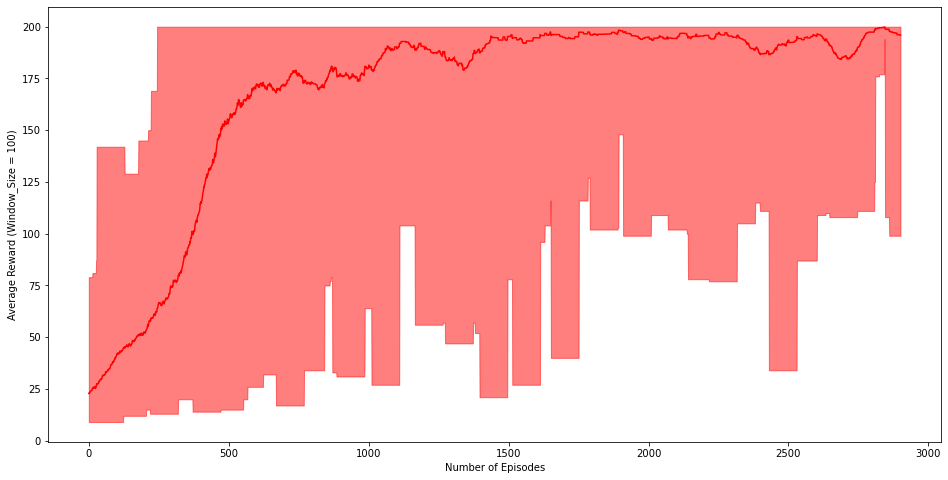

In [4]:
window_size = 100
average, min_returns, max_returns = return_stats(reward_history,window_size)
plt.figure(figsize = (16,8))
plot_mean_confInterv(average,min_returns,max_returns,'r','r')
plt.xlabel("Number of Episodes")
plt.ylabel("Average Reward (Window_Size = {})".format(window_size))
plt.show()

### Length of Episodes v/s Number of Episodes

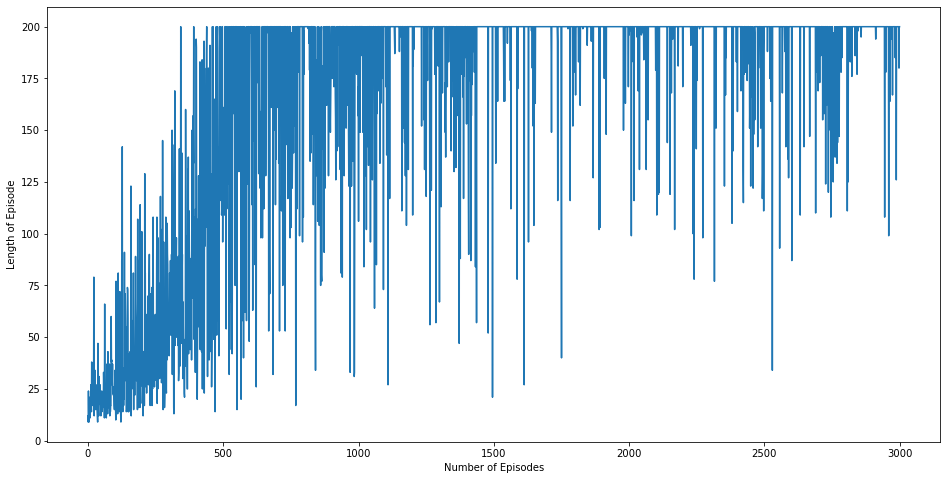

In [5]:
plt.figure(figsize = (16,8))
plt.plot(reward_history)
plt.ylabel("Length of Episode")
plt.xlabel("Number of Episodes")
plt.show()

### Testing

In [6]:
print('Variance of  disc. rewards: ',np.var(agent.var_reward))
for i in range(10):
    test_cp(agent,env,False)

Variance of  disc. rewards:  15070001.496449172

200.0

200.0

200.0

200.0

200.0

200.0

200.0

200.0

200.0

200.0


### VPG with baseline

In [7]:
agent_b = CartPole_agent(env,learning_rate=3e-4,gamma=0.99)
reward_history_b = agent_b.train(max_episode = 2000,baseline = True)

Episode: 2000, Episode Reward: 145.0, Average Reward: 184.74747474747474

### Average Reward of Episodes v/s Number of Episodes

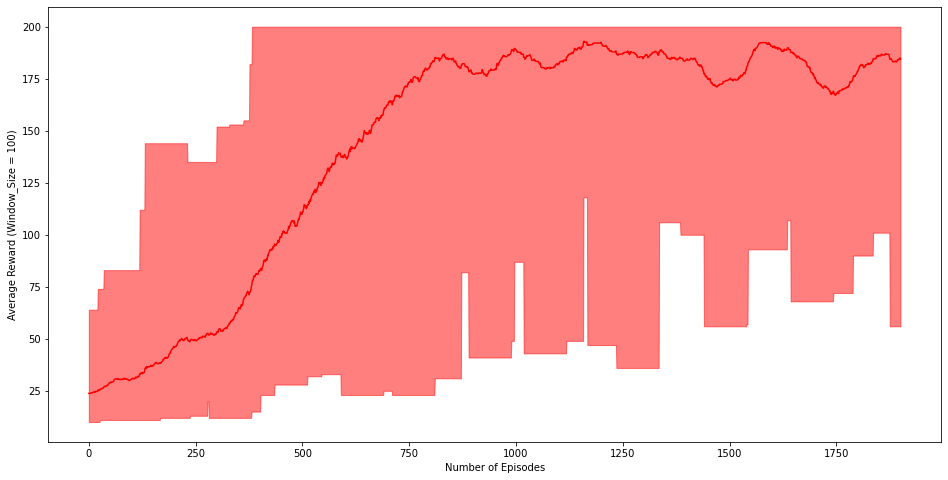

In [8]:
window_size = 100
average, min_returns, max_returns = return_stats(reward_history_b,window_size)
plt.figure(figsize = (16,8))
plot_mean_confInterv(average,min_returns,max_returns,'r','r')
plt.xlabel("Number of Episodes")
plt.ylabel("Average Reward (Window_Size = {})".format(window_size))
plt.show()

### Length of Reward v/s Number of Episodes.

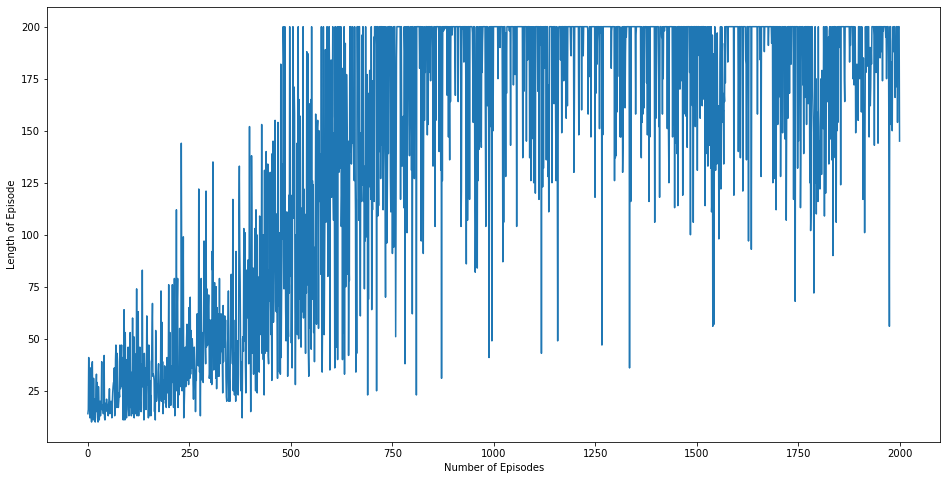

In [9]:
plt.figure(figsize = (16,8))
plt.plot(reward_history_b)
plt.ylabel("Length of Episode")
plt.xlabel("Number of Episodes")
plt.show()

### Testing

In [10]:
for i in range(10):
    test_cp(agent_b,env,False)
    
print('Variance of  disc. rewards: ',np.var(agent_b.var_reward))


56.0

200.0

200.0

180.0

200.0

188.0

200.0

200.0

200.0

69.0
Variance of  disc. rewards:  1.2528633553038004e-10


### Actor-Critic Method for CartPole-VO

Actor Critic Algorithm takes various forms based on the baseline chosen.
- Q Actor-Critic
\begin{equation}
    \nabla_{\theta}J(\theta) = E[\nabla_{\theta}\log\pi_{\theta}(s,a)Q^{w}(s,a)]
\end{equation}
- Advantage Actor Critic
\begin{equation}
    \nabla_{\theta}J(\theta) = E[\nabla_{\theta}\log\pi_{\theta}(s,a)A^{w}(s,a)]
\end{equation}
- In Actor-Critic Methods,
    * The "Critic" estimates the value function.This could be the action-value ($Q$ value) or the state-value ($v$ value)
    * The "Actor" updates the policy distribution in the direction suggested by the Critic. 
- Advantage-Actor Critic Method has the gradient of the objective function as follows:
\begin{equation}
   \nabla_{\theta}J(\theta) \approx \sum_{t=0}^{T-1}\nabla_{theta}\log\pi_{\theta}(a_{t}|s_{t})A(s_{t},a_{t})
\end{equation}
where,
\begin{equation}
    A(s_{t},a_{t}) = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{equation}

In [11]:
agent = ActorCritic_agent(env,learning_rate = 3e-2,gamma = 0.99)
rewards_history_ac = agent.train(max_episode = 2000)

Episode: 2000, Episode Reward: 200.0, Average Reward: 200.00404040404042

### Average Rewards v/s Number of Episodes

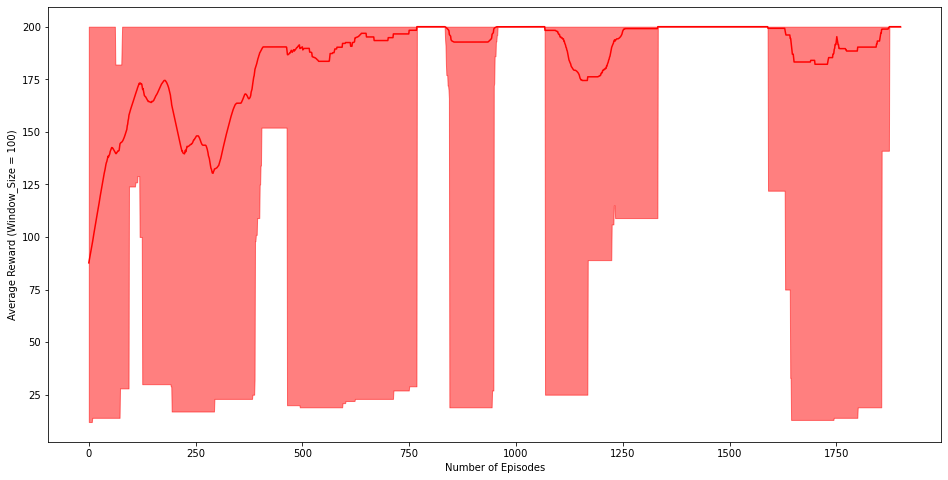

In [12]:
window_size = 100
average, min_returns, max_returns = return_stats(rewards_history_ac,window_size)
plt.figure(figsize = (16,8))
plot_mean_confInterv(average,min_returns,max_returns,'r','r')
plt.xlabel("Number of Episodes")
plt.ylabel("Average Reward (Window_Size = {})".format(window_size))
plt.show()

### Plot of Length of Episode v/s Number of Episodes.

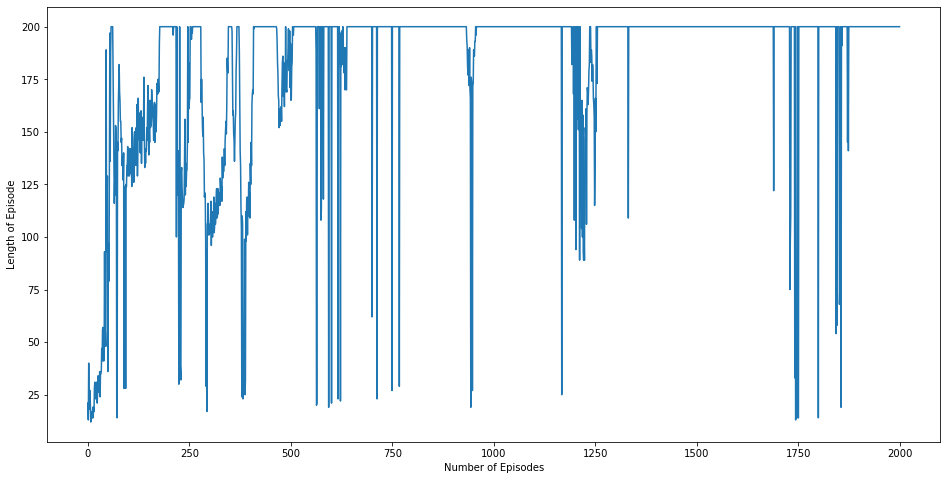

In [13]:
plt.figure(figsize = (16,8))
plt.plot(rewards_history_ac)
plt.ylabel("Length of Episode")
plt.xlabel("Number of Episodes")
plt.show()

### Testing

In [14]:
for i in range(10):
    test_ac_cartpole(agent,env,False)


200.0

200.0

200.0

200.0

200.0

200.0

200.0

200.0

200.0

200.0
